In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests

minimal_player_count_to_filter = 10

minimal_rating_to_consider = 2000 # When we get to player ranked less than that. we stop
minimal_country_population = 1000000

In [2]:
failures = []
def scrape_chess_leaderboard_full(page=1):
    url = f"https://www.chess.com/leaderboard/live?page={page}"
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options=options)

    driver.get(url)
    time.sleep(5)  # Wait for JS to load

    rows = driver.find_elements(By.CSS_SELECTOR, "tr.leaderboard-row-show-on-hover")
    data = []

    for row in rows:
        try:
            # Player name
            name_elem = row.find_element(By.CLASS_NAME, "cc-user-username-component")
            name = name_elem.text.strip()
            country = "unknown"
            try:
                # Country code (your method)
                country_div = row.find_element(By.CSS_SELECTOR, "div[class*='country-']")
                country_classes = country_div.get_attribute("class").split()
                country = [c for c in country_classes if c.startswith("country-") and "flags" not in c][0]
                country_code = country.split("-")[1]
            except:
                failures.append(name)
            rating = "-1"
            try:   
                # Rating
                rating_elem = row.find_elements(By.CSS_SELECTOR, "td.leaderboard-table-text-right")[1]
                rating = rating_elem.text.strip()
            except: 
                failures.append(name)
                
            data.append({
                "Player Name": name,
                "Country Code": country_code,
                "Rating": rating
            })

        except Exception as e:
            print(f"failure: {e}")  # Skip any row that causes an error

    driver.quit()

    return pd.DataFrame(data)

In [4]:
# Example usage
all_data = []
page = 1
while(True):
    print(f"Scraping page {page}")
    df = scrape_chess_leaderboard_full(page)
    all_data.append(df)
    min_value = df["Rating"].min()
    page +=1
    if (int(min_value) < minimal_rating_to_consider):
        break

final_df = pd.concat(all_data, ignore_index=True)
df.to_excel('raw_data.xlsx', index=False)
df.to_pickle('raw_data.pkl')


Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
failure: cannot access local variable 'country_code' where it is not associated with a value
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
failure: cannot access local variable 'country_code' where it is not associated with a value
Scraping page 16
Scraping page 17
Scraping page 18
failure: cannot access local variable 'country_code' where it is not associated with a value
Scraping page 19
failure: cannot access local variable 'country_code' where it is not associated with a value
Scraping page 20
Scraping page 21
Scraping page 22
Scraping page 23
Scraping page 24
Scraping page 25
Scraping page 26
Scraping page 27
Scraping page 28
Scraping page 29
Scraping page 30
Scraping page 31
Scraping page 32
Scraping page 33
Scraping page 34
Scraping page 35
Scraping page 36
Scraping page 37
Scraping

## Group by country

In [5]:
players_by_country = final_df.groupby("Country Code").size().reset_index(name="Player Count")

In [6]:
import json

with open("country_mapping.json", "r", encoding="utf-8") as f:
    country_codes = json.load(f)
with open("countries_population.json", "r", encoding="utf-8") as f:
    country_population = json.load(f)

In [7]:
name_to_population = dict()
for i in country_population:
    name_to_population[i["Country Name"]] = i["Population"]

In [8]:
code_to_name = {entry["id"]: entry["name"] for entry in country_codes}


In [9]:
# Define a function
def country_name(row):
    t = row["Country Code"]
    return code_to_name[int(t)]

final_df["country_name"] = final_df.apply(country_name, axis=1)


In [10]:
final_df

,Player Name,Country Code,Rating,country_name
0,Hikaru,2,3363,United States
1,MagnusCarlsen,104,3272,Norway
2,LyonBeast,52,3235,France
3,FabianoCaruana,2,3208,United States
4,Firouzja2003,52,3200,France
...,...,...,...,...
12885,GodSword3,86,1999,Lebanon
12886,soren20,41,1999,Denmark
12887,DOREZOHU,317,1999,Kosovo
12888,firerob,2,1999,United States


In [11]:
missing_populations = dict()
def country_population(row):
    t = row["country_name"]
    if (t in name_to_population):
        return name_to_population[t]
    if (t in missing_populations):
        missing_populations[t] = missing_populations[t]+1
    else:
        missing_populations[t]=1
    return 1
    

final_df["country_population"] = final_df.apply(country_population, axis=1)


In [12]:
missing_populations

{'International': 236,
 'Olympic': 5,
 'England': 46,
 'Palestine': 41,
 'Turks & Caicos Islands': 2,
 'Hong Kong SAR China': 17,
 'European Union': 32,
 'Catalonia': 39,
 'Canary Islands': 8,
 'St. Kitts & Nevis': 6,
 'Isle of Man': 4,
 'Chinese Taipei': 1,
 'Basque Country': 10,
 'Jersey': 1,
 'Scotland': 25,
 'Vatican City': 13,
 'Galicia': 7,
 '\\u00c5land Islands': 1,
 'U.S. Virgin Islands': 6,
 'St. Pierre & Miquelon': 5,
 'Paralympic': 2,
 'Laos': 1,
 'Cura\\u00e7ao': 2,
 'Wales': 11,
 'Trinidad & Tobago': 5,
 'R\\u00e9union': 4,
 'Cape Verde': 4,
 'Guernsey': 1,
 'St. Vincent & Grenadines': 2,
 'Antigua & Barbuda': 4,
 'The Gambia': 1,
 'Micronesia': 1,
 'Congo - Brazzaville': 1,
 'French Guiana': 1,
 'Anguilla': 1,
 'Martinique': 1,
 'Niue': 1}

In [13]:
final_df

,Player Name,Country Code,Rating,country_name,country_population
0,Hikaru,2,3363,United States,334915000
1,MagnusCarlsen,104,3272,Norway,5520000
2,LyonBeast,52,3235,France,68287000
3,FabianoCaruana,2,3208,United States,334915000
4,Firouzja2003,52,3200,France,68287000
...,...,...,...,...,...
12885,GodSword3,86,1999,Lebanon,5773000
12886,soren20,41,1999,Denmark,5947000
12887,DOREZOHU,317,1999,Kosovo,1756000
12888,firerob,2,1999,United States,334915000


In [14]:
players_by_country = final_df.groupby("country_name").size().reset_index(name="Player Count")

In [15]:
players_by_country

,country_name,Player Count
0,Afghanistan,15
1,Albania,73
2,Algeria,39
3,American Samoa,2
4,Andorra,5
...,...,...
208,Wales,11
209,Yemen,6
210,Zambia,13
211,Zimbabwe,21


In [16]:
players_by_country["country_population"] = players_by_country.apply(country_population, axis=1)

In [17]:
players_by_country

,country_name,Player Count,country_population
0,Afghanistan,15,41455000
1,Albania,73,2746000
2,Algeria,39,46164000
3,American Samoa,2,48000
4,Andorra,5,81000
...,...,...,...
208,Wales,11,1
209,Yemen,6,39391000
210,Zambia,13,20724000
211,Zimbabwe,21,16341000


In [18]:
players_by_country["players per million"] = (players_by_country["Player Count"] / players_by_country["country_population"]) * 1_000_000


In [19]:
players_by_country

,country_name,Player Count,country_population,players per million
0,Afghanistan,15,41455000,3.618381e-01
1,Albania,73,2746000,2.658412e+01
2,Algeria,39,46164000,8.448141e-01
3,American Samoa,2,48000,4.166667e+01
4,Andorra,5,81000,6.172840e+01
...,...,...,...,...
208,Wales,11,1,1.100000e+07
209,Yemen,6,39391000,1.523191e-01
210,Zambia,13,20724000,6.272920e-01
211,Zimbabwe,21,16341000,1.285111e+00


In [20]:

# Filter for countries with more than 100 players
players_by_country = players_by_country[players_by_country["Player Count"] > minimal_player_count_to_filter].copy()
players_by_country = players_by_country[players_by_country["country_population"] > minimal_country_population].copy()


In [21]:
players_by_country

,country_name,Player Count,country_population,players per million
0,Afghanistan,15,41455000,0.361838
1,Albania,73,2746000,26.584122
2,Algeria,39,46164000,0.844814
5,Angola,13,36750000,0.353741
8,Argentina,175,45538000,3.842944
...,...,...,...,...
203,Uzbekistan,56,35652000,1.570739
206,Venezuela,51,28301000,1.802056
207,Vietnam,90,100352000,0.896843
210,Zambia,13,20724000,0.627292


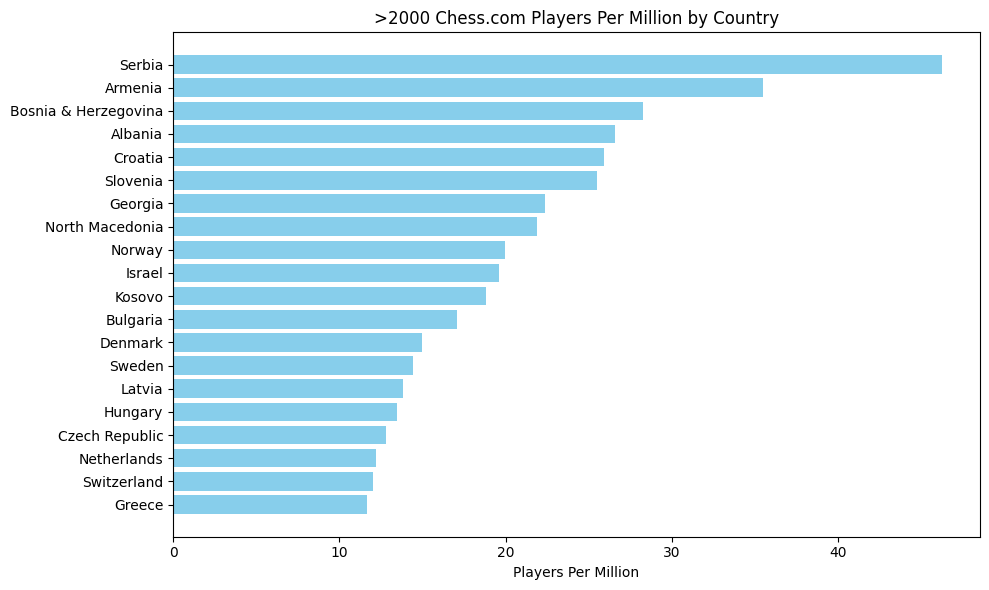

In [22]:
# Sort by value (optional)
df_sorted = players_by_country.sort_values("players per million", ascending=False)[:20]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_sorted["country_name"], df_sorted["players per million"], color='skyblue')
plt.xlabel("Players Per Million")
plt.title(f">{minimal_rating_to_consider} Chess.com Players Per Million by Country")
plt.gca().invert_yaxis()  # Highest value at the top
plt.tight_layout()
plt.show()